# Homework 4 - Nam Wook Kim (90948148)

## APMTH 207:  Stochastic Methods for Data Analysis, Inference and Optimization

**Due Date:** Thursday, Febrary 23rd, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization (Continued)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A: Further problems with descent algorithms
Using your implementation of gradient descent and stochastic gradient descent, document the behaviour of your two algorithms for the following starting points, and for a number of stepsizes of your choice:
- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$

Based on your analysis of the loss function $L$, explain what is happening to your descent algorithms.

In [2]:
import numpy as np
import pandas as pd
from scipy import stats 
import time
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
from functools import partial
%matplotlib inline

In [6]:
x, y = np.genfromtxt('HW3_data.csv', delimiter=',')

In [8]:
x_sum = x.sum()
y_sum = y.sum()
N = len(x)

#Total loss
L = lambda l1, l2, x, y: 0.000045 * l2**2 * y.sum() - 0.000098 * l1**2 * x.sum() + 0.003926 * x.sum() * l1 * np.exp(-0.1 * (l1**2 + l2**2))

In [5]:
#The gradient of the total loss function
grad = lambda l1, l2, x, y: np.array([-0.000098 * 2 * l1 * x.sum() 
                                      + 0.003926 *  x.sum() * np.exp(-0.1 * (l1**2 + l2**2)) 
                                      - 0.003926 * 2 * 0.1 *  x.sum() * l1**2 * np.exp(-0.1 * (l1**2 + l2**2)), 
                                      2 * 0.000045 * l2 * y.sum() 
                                      - 0.1 * 2* 0.003926 *  x.sum() * l1 * l2 * np.exp(-0.1 * (l1**2 + l2**2))])

In [6]:
#Gradient Descent
def gradient_descent(x, y, lambdas_init, init_shuffle=False, step_size=0.001, maxsteps=None, precision=1e-3, scaling=1.):
    
    lambdas = lambdas_init
    history = [lambdas] # to store all parameters
    counter = 0

    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]

    #Do descent while stopping condition not met
    while np.linalg.norm(history[-1] - np.array([2.05384, 0])) > precision:
        #get gradient of average loss function
        gradient = grad(lambdas[0], lambdas[1], x, y) * 1. / N
        #take one step in the gradient direction, scaling is just a scaling factor that adjusts the stepsize
        #of course you can just directly adjust the stepsize
        lambdas = lambdas -  step_size * gradient * scaling 
        #add our new parameters to the history
        history.append(lambdas)
        #tick off one more step
        counter +=1
        
        #if we've hit maximum steps allowed, stop!
        if maxsteps is not None:
            if counter == maxsteps:
                break
        
    return history

In [7]:
#Stochastic Gradient Descent
def sgd(x, y, lambdas_init, init_shuffle=False, step_size=0.001, max_epochs=1, precision=1e-3, scaling=1.):
    lambdas = lambdas_init
    history = [lambdas] # to store all thetas

    counter = 0
    epochs = 0
    i = 0 #index
        
    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]    
    
    #run through the data in multiple passes
    for epoch in range(max_epochs):
        #for each data point, compute the gradient and make an update to our parameters
#         print 'epoch: ', epoch 
        for i in range(N):
            #get gradient of average loss function
            gradient = grad(lambdas[0], lambdas[1], x[i], y[i])
            #take one step in the gradient direction, scaling is just a scaling factor that adjusts the stepsize
            #of course you can just directly adjust the stepsize
            lambdas = lambdas -  step_size * gradient * scaling 
            #add our new parameters to the history
            history.append(lambdas)   
            
            if np.linalg.norm(np.array(lambdas) - np.array([2.05384, 0])) < precision:
                return history, epoch
            elif np.any(np.isnan(lambdas)):
                return history[:-1], epoch
        
        #shuffle the data for the next pass thru
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]
    
    return history, max_epochs

In [14]:
def test(lambdas_inits, step_size=0.001):
    print '\n---------------------- step_size:', step_size, '----------------------\n'
    gd_losses = []
    sgd_losses = []
    for lambdas_init in lambdas_inits:
        print '\n****************** lambda init:', lambdas_init, '******************\n'
        print '1. GD'
        history = gradient_descent(x, y, lambdas_init, step_size=step_size, scaling=1000., maxsteps=100000)
        history = np.array(history)

        lambdas = history[-1]
        costs = L(history[:, 0], history[:, 1], x, y)

        print '- how many iters: ', len(history)
        print '- final cost:', costs[-1]
        print '- precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])
        print '\n'

        gd_losses.append(costs[-1])

        print '2. SGD'
        history, epoch = sgd(x, y, lambdas_init, init_shuffle=True, step_size=step_size, max_epochs=8, scaling=1000.)
        history = np.array(history)

        lambdas = history[-1]
        costs = L(history[:, 0], history[:, 1], x, y) 

        print '- how many iters: ', len(history)
        print '- final cost:', costs[-1]
        print '- precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])
        print '\n'

        sgd_losses.append(costs[-1])
        
    return gd_losses, sgd_losses



---------------------- step_size: 0.1 ----------------------


****************** lambda init: [-2.47865, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.16152869937
- precision to actual param: 7.41708926028


2. SGD
- how many iters:  25460
- final cost: -9.93410204361
- precision to actual param: 0.000877201161326



****************** lambda init: [-3, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.16152869937
- precision to actual param: 7.41708926028


2. SGD
- how many iters:  6586
- final cost: -9.93410402225
- precision to actual param: 2.69640235571e-05



****************** lambda init: [-5, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.16152869937
- precision to actual param: 7.41708926028


2. SGD
- how many iters:  44577
- final cost: -9.93410223605
- precision to actual param: 0.000833079970987



****************** lambda init: [-10, 0] ******************

1. GD
- how many iters:  100001
- final co

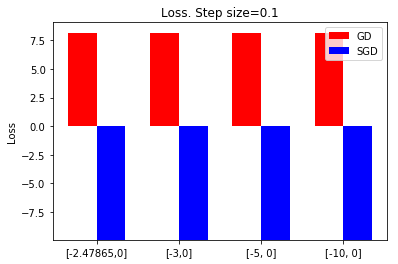

In [16]:
lambdas_inits = [[-2.47865,0], [-3,0], [-5,0], [-10,0]]

step_size = 0.1
gd_losses, sgd_losses = test(lambdas_inits, step_size)

ind = np.arange(len(gd_losses))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind, gd_losses, width, color='r')
rects2 = ax.bar(ind + width, sgd_losses, width, color='b')

ax.set_ylabel('Loss')
ax.set_title('Loss. Step size='+str(step_size))
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('[-2.47865,0]', '[-3,0]', '[-5, 0]', '[-10, 0]'))
ax.legend((rects1[0], rects2[0]), ('GD', 'SGD'))
plt.show()


---------------------- step_size: 0.01 ----------------------


****************** lambda init: [-2.47865, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.16152869937
- precision to actual param: 7.41708926027


2. SGD
- how many iters:  128001
- final cost: 11.9545803086
- precision to actual param: 4.53248625197



****************** lambda init: [-3, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.16152869937
- precision to actual param: 7.41708926027


2. SGD
- how many iters:  128001
- final cost: 11.9545803086
- precision to actual param: 4.53248625197



****************** lambda init: [-5, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.16152869937
- precision to actual param: 7.41708926027


2. SGD
- how many iters:  128001
- final cost: 8.16152869937
- precision to actual param: 7.41708926028



****************** lambda init: [-10, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.1615

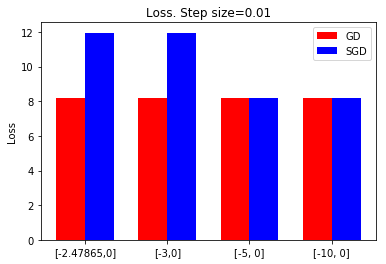

In [19]:
lambdas_inits = [[-2.47865,0], [-3,0], [-5,0], [-10,0]]

step_size = 0.01
gd_losses, sgd_losses = test(lambdas_inits, step_size)

ind = np.arange(len(gd_losses))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind, gd_losses, width, color='r')
rects2 = ax.bar(ind + width, sgd_losses, width, color='b')

ax.set_ylabel('Loss')
ax.set_title('Loss. Step size='+str(step_size))
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('[-2.47865,0]', '[-3,0]', '[-5, 0]', '[-10, 0]'))
ax.legend((rects1[0], rects2[0]), ('GD', 'SGD'))
plt.show()


---------------------- step_size: 0.001 ----------------------


****************** lambda init: [-2.47865, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.16251470164
- precision to actual param: 7.38334433089


2. SGD
- how many iters:  128001
- final cost: 11.9545803086
- precision to actual param: 4.53248625197



****************** lambda init: [-3, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.16152870393
- precision to actual param: 7.41701665634


2. SGD
- how many iters:  128001
- final cost: 11.9545803086
- precision to actual param: 4.53248625197



****************** lambda init: [-5, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.16152869942
- precision to actual param: 7.41708202146


2. SGD
- how many iters:  128001
- final cost: 8.16152869937
- precision to actual param: 7.41708926028



****************** lambda init: [-10, 0] ******************

1. GD
- how many iters:  100001
- final cost: 8.161

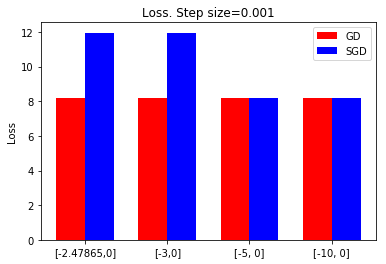

In [24]:
lambdas_inits = [[-2.47865,0], [-3,0], [-5,0], [-10,0]]

step_size = 0.001
gd_losses, sgd_losses = test(lambdas_inits, step_size)

ind = np.arange(len(gd_losses))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind, gd_losses, width, color='r')
rects2 = ax.bar(ind + width, sgd_losses, width, color='b')

ax.set_ylabel('Loss')
ax.set_title('Loss. Step size='+str(step_size))
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('[-2.47865,0]', '[-3,0]', '[-5, 0]', '[-10, 0]'))
ax.legend((rects1[0], rects2[0]), ('GD', 'SGD'))
plt.show()

Maybe I am wrong, but it is difficult to see any significant trends across different initial parameters. 

For the step size 0.01 and 0.001, SGD seems to decrease in loss as the init param is further away from the global minimum. 

### Part B: Simulated Annealing
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our lost function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

**Extra Credit**
For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

In [29]:

# proposal distribution
pfxs = lambda s, x: x + s*np.random.multivariate_normal([0,0],[[1,0],[0,1]])
pf = partial(pfxs, 0.1)

tf = lambda t: 0.8*t #temperature function
itf = lambda length: int(math.ceil(1.2*length)) #iteration function

f = partial(L, x=x, y=y)

In [33]:
def sa(ef, inits, epochs, tf, itf, pf):
    acc = []
    best_sol = old_sol = inits['sol']
    T = inits['T']
    length = inits['len']
    best_eng = old_eng = ef(*old_sol)
    accepted = 0
    total = 0
    for i in xrange(epochs):
        print 'Epoch', i
        if i>0:
            T = tf(T)
            length = itf(length)
        print 'T:', T, ', Length:', length
        for it in xrange(length):
            total+=1
            new_sol = pf(old_sol)
            new_eng  = ef(*new_sol)
            alpha = min(1, np.exp((old_eng-new_eng)/T))
            if ((new_eng < old_eng) or (np.random.uniform() < alpha)):
                accepted +=1
                acc.append((T, new_sol, new_eng))
                if new_eng < best_eng:
                    best_eng = new_eng
                    best_sol = new_sol
                    best_idx = total
                    best_temp = T 
                old_eng = new_eng
                old_sol = new_sol
            else:
                acc.append((T,old_sol,old_eng))
                
    best_meta = dict(index = best_idx, temp = best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_sol, best_eng, acc

In [34]:
inits=dict(sol=[-5,0], len=500, T=10)
bmeta, bs, be, out = sa(f, inits, 30, tf, itf, pf)

Epoch 0
T: 10 , Length: 500
Epoch 1
T: 8.0 , Length: 600
Epoch 2
T: 6.4 , Length: 720
Epoch 3
T: 5.12 , Length: 864
Epoch 4
T: 4.096 , Length: 1037
Epoch 5
T: 3.2768 , Length: 1245
Epoch 6
T: 2.62144 , Length: 1494
Epoch 7
T: 2.097152 , Length: 1793
Epoch 8
T: 1.6777216 , Length: 2152
Epoch 9
T: 1.34217728 , Length: 2583
Epoch 10
T: 1.073741824 , Length: 3100
Epoch 11
T: 0.8589934592 , Length: 3720
Epoch 12
T: 0.68719476736 , Length: 4464
Epoch 13
T: 0.549755813888 , Length: 5357
Epoch 14
T: 0.43980465111 , Length: 6429
Epoch 15
T: 0.351843720888 , Length: 7715
Epoch 16
T: 0.281474976711 , Length: 9258
Epoch 17
T: 0.225179981369 , Length: 11110
Epoch 18
T: 0.180143985095 , Length: 13332
Epoch 19
T: 0.144115188076 , Length: 15999
Epoch 20
T: 0.115292150461 , Length: 19199
Epoch 21
T: 0.0922337203685 , Length: 23039
Epoch 22
T: 0.0737869762948 , Length: 27647
Epoch 23
T: 0.0590295810359 , Length: 33177
Epoch 24
T: 0.0472236648287 , Length: 39813
Epoch 25
T: 0.037778931863 , Length: 47776

In [35]:
bs

array([  2.05374087e+00,   1.60707616e-04])

In [36]:
be

-9.9341039630229275

In [38]:
print '- final cost:', be
print '- precision to actual param:', np.linalg.norm(bs - [2.05384, 0])

- final cost: -9.93410396302
- precision to actual param: 0.000188821922947


The result is comparable to that of SGD (step size = 0.1, init = [-5,0])